In [1]:
import os
import tomopy
import numpy as np
import matplotlib.pyplot as plt
import sys
root_folder = os.path.dirname(os.getcwd())
sys.path.append(root_folder)
import utilities as rocku
import dxchange
import algotom.prep.correction as corr
import neutompy as ntp
import algotom.prep.calculation as calc
import algotom.rec.reconstruction as rec
import algotom.prep.removal as rem
import h5py as h5f
from tqdm import tqdm
import timeit
import multiprocessing as mp
import svmbir

# %matplotlib notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
ncore = mp.cpu_count()
print("CPU cores:", ncore)

CPU cores: 64


# Workflow starts here!

In [2]:
###################### need to change start
# instrument = "/HFIR/CG1D"
instrument = "/SNS/VENUS"
ipts = "33531"
###################### need to change end

## Find CT scan location

In [3]:
# ct_loc = instrument + "/IPTS-"+ipts+"/shared/processed_data"
# ct_loc = instrument + "/IPTS-"+ipts+"/raw/ct_scans"
ct_loc = instrument + "/IPTS-"+ipts+"/shared/processed_data"
# ct_loc = instrument + "/IPTS-"+ipts+"/shared/autoreduce/rockit"
# ct_loc = instrument + "/IPTS-"+ipts+"/shared/autoreduce/raw_to_recon"
sorted(os.listdir(ct_loc))

['CT_car_1',
 'November8_2024_PlantE',
 'November9_2024_Soil_microplastics_1',
 'October30_2024',
 'dc',
 'jean_test',
 'ob',
 'ob_PlantE',
 'remove_me',
 'step1_prepare_white_beam_mode_images.log',
 'step1_trunk_CT_data_01m_22d_2025y_13h_52mn.json',
 'step2_slice_white_beam_mode_images_01m_22d_2025y_13h_58mn.json',
 'test_cleaning_qhy_data',
 'truck_CT_data',
 'trunk_CT_data_normalized',
 'trunk_CT_data_projections_pre_data_01m_22d_2025y_13h_52mn']

## Find OB location

In [4]:
# ob_loc = "/HFIR/CG1D/IPTS-"+ipts+"/shared/processed_data"
# ob_loc = "/HFIR/CG1D/IPTS-"+ipts+"/raw/ob"
ob_loc = "/SNS/VENUS/IPTS-"+ipts+"/shared/processed_data"
# ob_loc = "/HFIR/CG1D/IPTS-"+ipts+"/shared/autoreduce/rockit"
# ob_loc = "/HFIR/CG1D/IPTS-"+ipts+"/shared/autoreduce/raw_to_recon"
sorted(os.listdir(ob_loc))

['CT_car_1',
 'November8_2024_PlantE',
 'November9_2024_Soil_microplastics_1',
 'October30_2024',
 'dc',
 'jean_test',
 'ob',
 'ob_PlantE',
 'remove_me',
 'step1_prepare_white_beam_mode_images.log',
 'step1_trunk_CT_data_01m_22d_2025y_13h_52mn.json',
 'step2_slice_white_beam_mode_images_01m_22d_2025y_13h_58mn.json',
 'test_cleaning_qhy_data',
 'truck_CT_data',
 'trunk_CT_data_normalized',
 'trunk_CT_data_projections_pre_data_01m_22d_2025y_13h_52mn']

## Find DC location

In [5]:
# dc_loc = "/HFIR/CG1D/IPTS-"+ipts+"/shared/processed_data"
# dc_loc = "/HFIR/CG1D/IPTS-"+ipts+"/raw/dc"
dc_loc = "/SNS/VENUS/IPTS-"+ipts+"/shared/processed_data/dc"
# dc_loc = "/HFIR/CG1D/IPTS-32298/raw/dc"
# dc_loc = "/HFIR/CG1D/IPTS-"+ipts+"/shared/autoreduce/rockit"
# dc_loc = "/HFIR/CG1D/IPTS-"+ipts+"/shared/autoreduce/raw_to_recon"
sorted(os.listdir(dc_loc))

['45s']

In [12]:
###################### need to change start
sample_name = "truck_CT_data"
ct_dir = os.path.join(ct_loc, sample_name)
ob_dir = os.path.join(ob_loc, "ob")
dc_dir = os.path.join(dc_loc, "45s")
# ct_dir = "/HFIR/CG1D/IPTS-"+ipts+"/shared/processed_data/raw_to_recon"
# ob_dir = "/HFIR/CG1D/IPTS-"+ipts+"/shared/processed_data/raw_to_recon"
# dc_dir = "/HFIR/CG1D/IPTS-"+ipts+"/shared/processed_data/raw_to_recon"
###################### need to change end
gamma_diff = 20
img_per_ang = 1
mars_ct = True
# mars_ct = False
# golden_ratio = True
golden_ratio = False
filter_name = None  # can be used to seperate 2 CTs in the same folder
end_ang = 360 # Will *NOT* be used if the CT file names contain angle info
ct_name = "*projection*" # Will not be used if follows the default file structure
ob_name = "*OB*" # Will not be used if follows the default file structure
dc_name = "*DC*" # Will not be used if follows the default file structure
svmbir_path = instrument + "/IPTS-"+ipts+"/shared/autoreduce/svmbir/"

# Load all data files (CT, OB and DC)

In [13]:
history_dict = {}
######### CT
proj_raw, ang_deg, ang_rad, proj180_idx, proj000_idx, fname_sorted = rocku.load_ct(ct_dir, ang2=end_ang, name=ct_name, 
                                                                                   filter_name=filter_name, img_per_ang=img_per_ang,
                                                                                  mars_ct=mars_ct, golden_ratio=golden_ratio)
######### OB
ob_raw = rocku.load_ob(ob_dir, name=ob_name)
######### DC
dc_raw = rocku.load_dc(dc_dir, name=dc_name)

Normal CT naming convention
181


Found index of 180 degree projections: 180 of angle 180.0
Found index of 0 degree projections: 0 of angle 0.0
Loading 181 CT projections...
181 CT projections loaded!
Shape: (181, 6422, 9600)
Loading 5 Open Beam (OB) images...
5


5 Open Beam (OB) images loaded!
Shape: (5, 6422, 9600)
Loading 5 Dark Current (DC) images...
5


5 Dark Current (DC) images loaded!
Shape: (5, 6422, 9600)


# Visual verification of loaded files

Time: 1.303650206886232 s


IndexError: index 359 is out of bounds for axis 0 with size 181

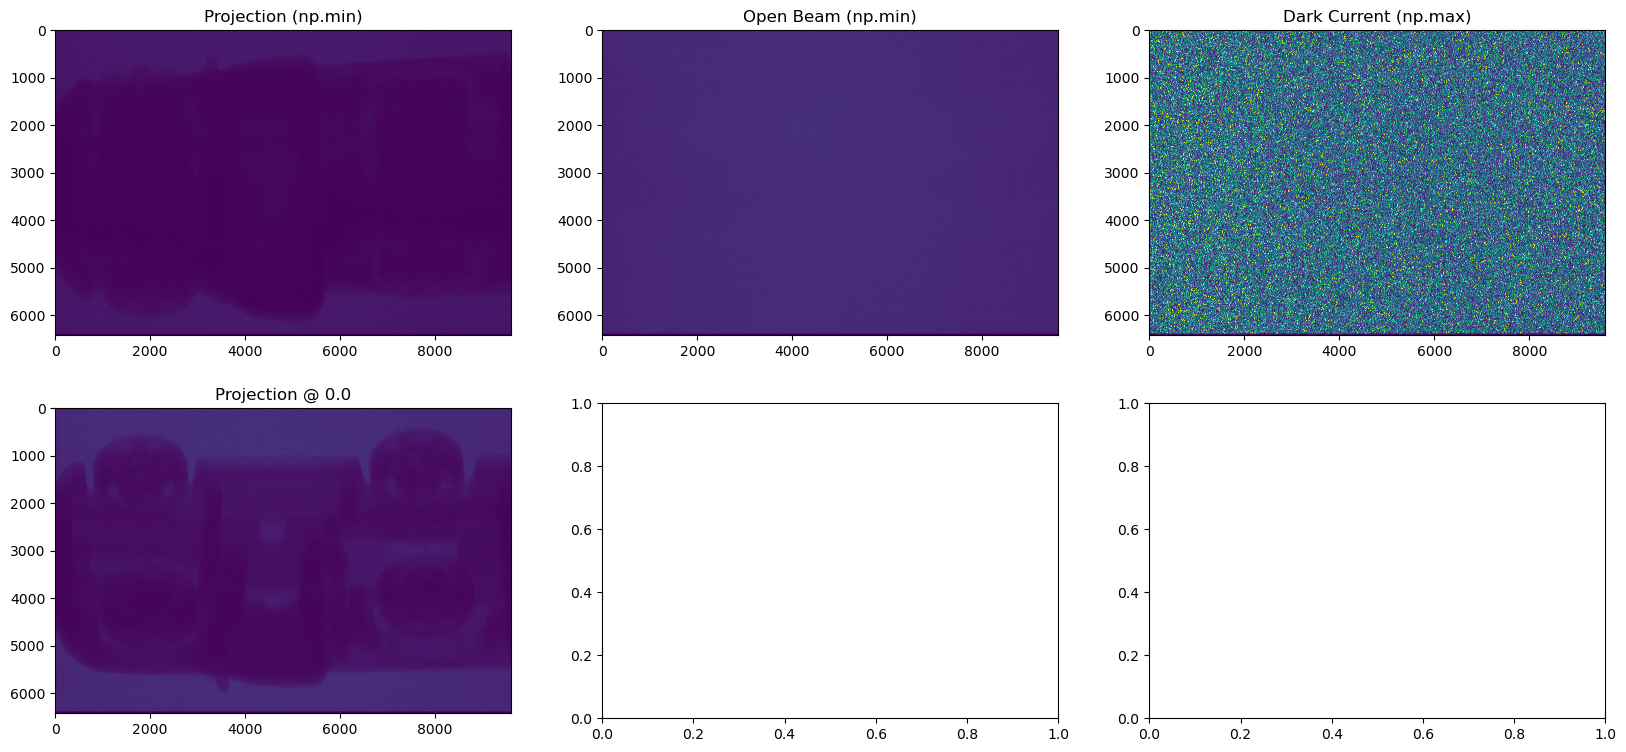

In [14]:
vmax = tomopy.misc.corr.remove_outlier(ob_raw[0], gamma_diff, ncore=ncore).astype(np.ushort).max()
vmin = tomopy.misc.corr.remove_outlier(proj_raw[0], gamma_diff, ncore=ncore).astype(np.ushort).min()
##################
t0 = timeit.default_timer()
proj_min = np.min(proj_raw, axis=0)
ob_min = np.min(ob_raw, axis=0)
dc_max = np.max(dc_raw, axis=0)
proj360_idx = proj180_idx*2-1
t1 = timeit.default_timer()
print("Time: {} s".format(t1-t0))
f, ax = plt.subplots(2, 3, figsize=(20, 9))
ax[0][0].imshow(proj_min, vmax=vmax, vmin=vmin)
ax[0][0].set_title('Projection (np.min)')
ax[0][1].imshow(ob_min, vmax=vmax, vmin=vmin)
ax[0][1].set_title('Open Beam (np.min)')
ax[0][2].imshow(dc_max, vmax=vmin+1000, vmin=vmin)
ax[0][2].set_title('Dark Current (np.max)')
ax[1][0].imshow(proj_raw[0], vmax=vmax, vmin=vmin)
ax[1][0].set_title('Projection @ {}'.format(ang_deg[0]))
ax[1][1].imshow(proj_raw[proj360_idx], vmax=vmax, vmin=vmin)
ax[1][1].set_title('Projection @ {}'.format(ang_deg[proj360_idx]))
ax[1][2].imshow(proj_raw[proj360_idx]/proj_raw[0], vmax=1.1, vmin=0.9)
ax[1][2].set_title('Ratio')

# Resize/crop

Cropped:


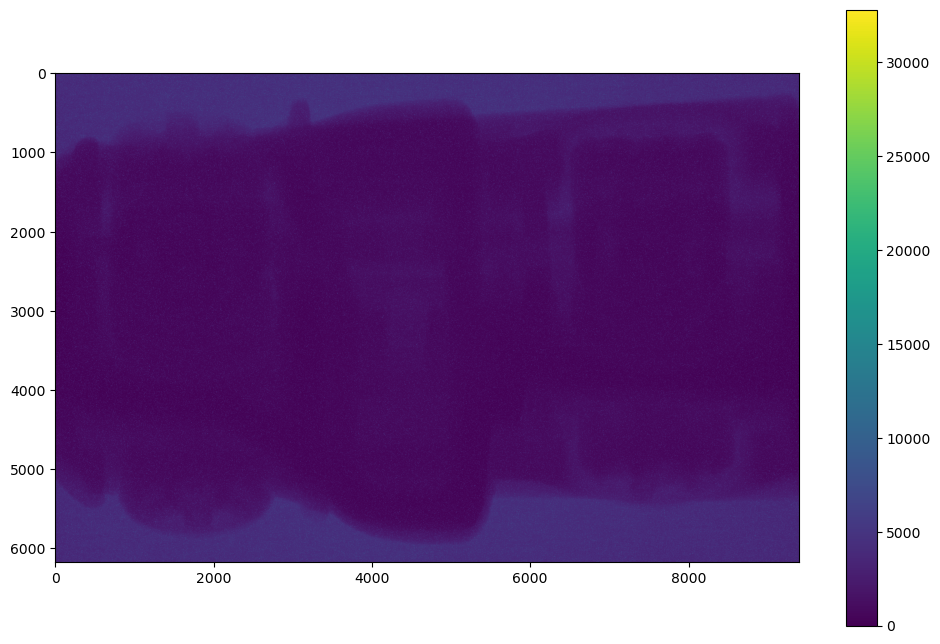

In [61]:
###################### need to change start
# crop = False
crop = True

crop_left = 200#950
crop_right = -1#3850
###################### need to change end
crop_top = 200
crop_bottom = -50
proj_crop = rocku.crop(proj_raw, crop_left, crop_right, crop_top, crop_bottom, crop)
ob_crop = rocku.crop(ob_raw, crop_left, crop_right, crop_top, crop_bottom, crop)
dc_crop = rocku.crop(dc_raw, crop_left, crop_right, crop_top, crop_bottom, crop)
proj_crop_min = rocku.crop(proj_min, crop_left, crop_right, crop_top, crop_bottom, crop)
print("Cropped:")
plt.imshow(proj_crop_min, vmax=vmax/2)
plt.colorbar()
plt.show()
crop_roi_dict = {
    'left': crop_left,
    'right': crop_right,
    'top': crop_top,
    'bottom': crop_bottom
}
history_dict = rocku.log(history_dict, 'crop', crop)
if crop:
    history_dict = rocku.log(history_dict, 'crop_roi_dict', crop_roi_dict)

# Remove Outliers

In [62]:
t0 = timeit.default_timer()
proj_crop = tomopy.misc.corr.remove_outlier(proj_crop, gamma_diff, ncore=ncore).astype(np.ushort)
ob_crop = tomopy.misc.corr.remove_outlier(ob_crop, gamma_diff, ncore=ncore).astype(np.ushort)
dc_crop = tomopy.misc.corr.remove_outlier(dc_crop, gamma_diff, ncore=ncore).astype(np.ushort)
# proj_crop = tomopy.misc.corr.remove_outlier_cuda(proj_crop, gamma_diff).astype(np.ushort)
# ob_crop = tomopy.misc.corr.remove_outlier_cuda(ob_crop, gamma_diff).astype(np.ushort)
# dc_crop = tomopy.misc.corr.remove_outlier_cuda(dc_crop, gamma_diff).astype(np.ushort)
t1 = timeit.default_timer()
print("Time: {} s".format(t1-t0))
history_dict = rocku.log(history_dict, 'gamma_filter', True)
history_dict = rocku.log(history_dict, 'gamma_diff', gamma_diff)

Time: 45.147117749089375 s


# Rebin Pixels

In [64]:
pixel_bin_size = 1
# pixel_bin_size = 2
func = np.sum
# dtype = np.float16
dtype = np.float32
# dtype = np.float64
#################################################
t0 = timeit.default_timer()
proj_crop_resized = rocku.bin_pix(proj_crop, pixel_bin_size=pixel_bin_size, func=func, dtype=dtype)
ob_crop_resized = rocku.bin_pix(ob_crop, pixel_bin_size=pixel_bin_size, func=func, dtype=dtype)
dc_crop_resized = rocku.bin_pix(dc_crop, pixel_bin_size=pixel_bin_size, func=func, dtype=dtype)
proj_crop_min_resized = rocku.bin_pix(proj_crop_min, pixel_bin_size=pixel_bin_size, func=func, dtype=dtype)
t1 = timeit.default_timer()
print("Time: {} s".format(t1-t0))

Pixel_bin_size = 1, no binning
Pixel_bin_size = 1, no binning
Pixel_bin_size = 1, no binning
Pixel_bin_size = 1, no binning
Time: 0.00012034992687404156 s


# Normalization

OB stack combined by median.
DC stack combined by median.
Normalization Done!
float32
(181, 6172, 9399)
Normalization Time: 12.598833828000352 s


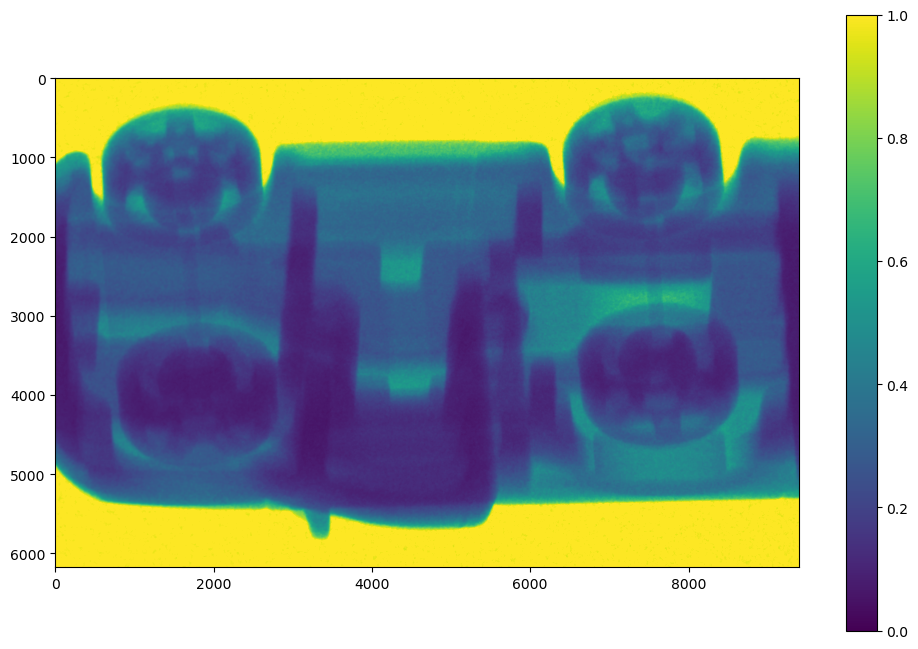

In [65]:
#################################################
t0 = timeit.default_timer()
proj_norm, proj_mi_dc, ob_med, dc_med = rocku.normalize(proj_crop_resized, ob_crop_resized, dc_crop_resized)
print(proj_norm.dtype)
print(proj_norm.shape)
t1 = timeit.default_timer()
print("Normalization Time: {} s".format(t1-t0))
proj_norm = rocku.remove_nan(proj_norm, val=0, ncore=ncore)
proj_norm = rocku.remove_neg(proj_norm, val=0, ncore=ncore)
plt.imshow(proj_norm[0], vmin=0, vmax=1)
plt.colorbar()
plt.show()
history_dict = rocku.log(history_dict, 'normalization', True)
history_dict = rocku.log(history_dict, 'pixel_bin_size', pixel_bin_size)

# Beam fluctuation correction (optional)

Beam fluctuation ROI:


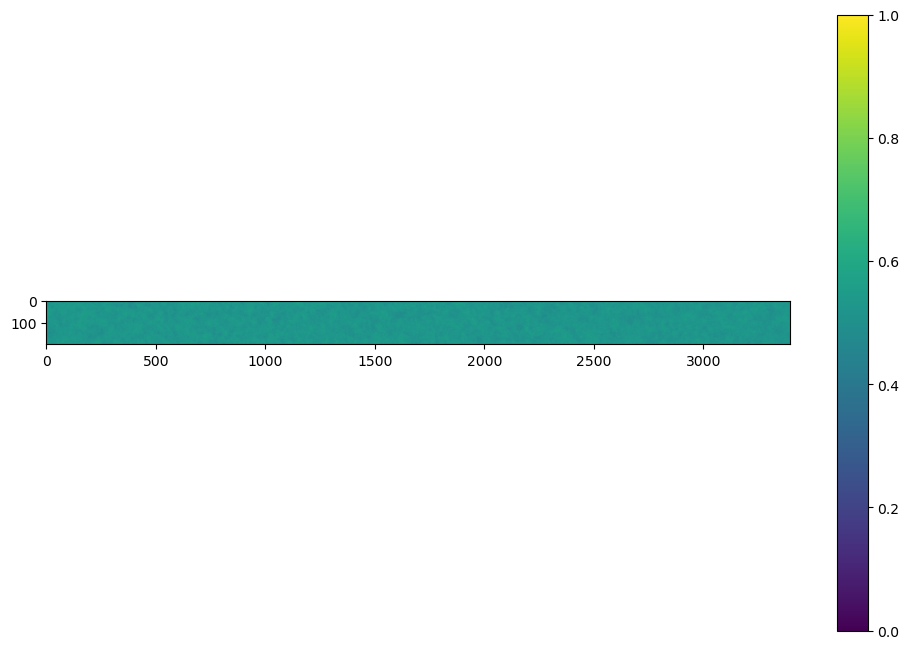

In [66]:
###################### need to change start
fluc_corr = True
# fluc_corr = False
bg_left = 6000
bg_right = -1
bg_top = -200#750
bg_bottom = -1#3000
###################### need to change end
if fluc_corr:
    bg_stack = proj_norm[:, bg_top:bg_bottom, bg_left:bg_right]
    bg_min = np.min(bg_stack, axis=0)
    print("Beam fluctuation ROI:")
    plt.imshow(bg_min, vmin=0, vmax=1)
    plt.colorbar()
    plt.show()

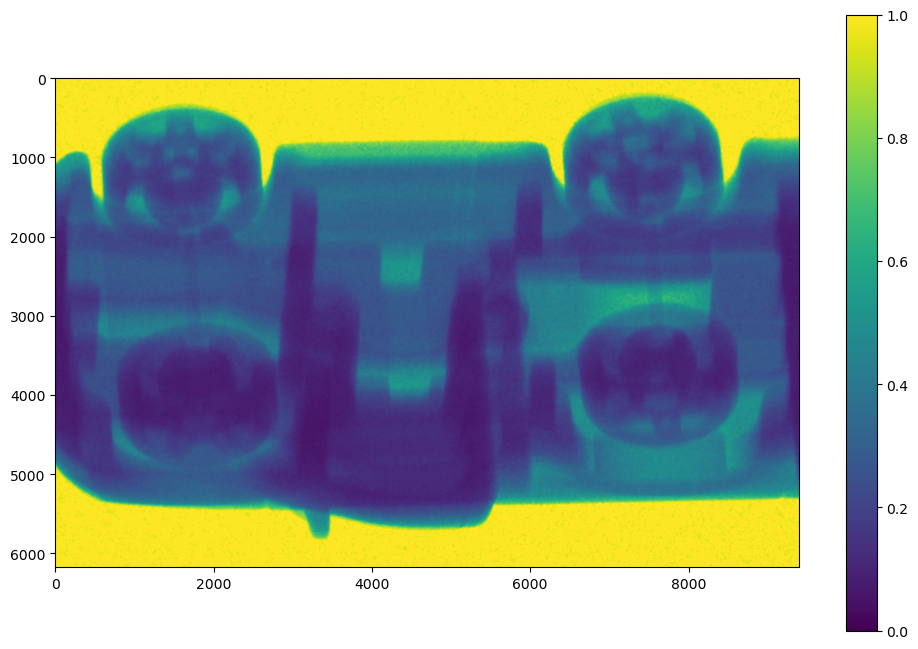

Time: 53.26898024184629 s


In [67]:
if fluc_corr:
    t0 = timeit.default_timer()
    proj_norm = tomopy.prep.normalize.normalize_roi(proj_norm, roi= [bg_top, bg_left, bg_bottom, bg_right], ncore=ncore)
    plt.imshow(proj_norm[0], vmin=0, vmax=1)
    plt.colorbar()
    plt.show()
    t1 = timeit.default_timer()
    print("Time: {} s".format(t1-t0))
    bg_roi_dict = {
        'left': bg_left,
        'right': bg_right,
        'top': bg_top,
        'bottom': bg_bottom
    }
    history_dict = rocku.log(history_dict, 'beam_fluc_corr', fluc_corr)
    history_dict = rocku.log(history_dict, 'beam_fluc_corr_roi_dict', bg_roi_dict)

# Minus log conversion

Minus Log Time: 1.3090513669885695 s


/SNS/users/y9z/miniconda3/envs/rockit/lib/python3.10/site-packages/tomopy/misc/corr.py:747: UserWarning: The tomocuda is not support, using cpu outlier removal
  warnings.warn("The tomocuda is not support, using cpu outlier removal")


Outlier Removal Time: 22.240573408082128 s


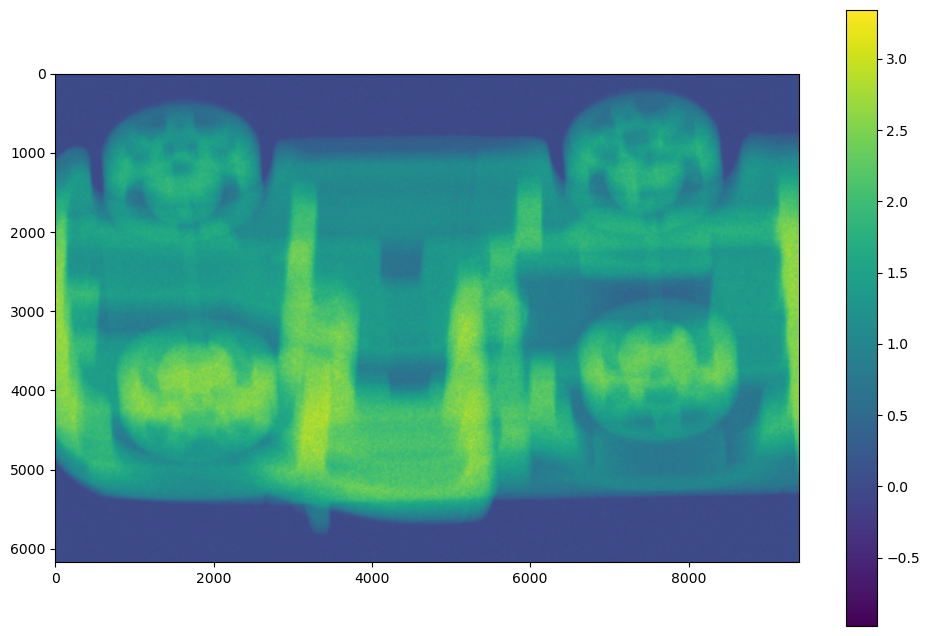

In [68]:
t0 = timeit.default_timer()
# _proj_norm = proj_norm[:]
proj_mlog = tomopy.minus_log(proj_norm, ncore=ncore, out=None)
t1 = timeit.default_timer()
history_dict = rocku.log(history_dict, 'minus_log', True)
print("Minus Log Time: {} s".format(t1-t0))
## Optional to removal outliers again in mlog
mlog_diff = 0.2
t0 = timeit.default_timer()
proj_mlog = tomopy.misc.corr.remove_outlier_cuda(proj_mlog, mlog_diff)
t1 = timeit.default_timer()
print("Outlier Removal Time: {} s".format(t1-t0))
proj_mlog = rocku.remove_neg(proj_mlog, val=0, ncore=ncore)
sino_mlog = np.moveaxis(proj_mlog, 1, 0)
plt.imshow(proj_mlog[0])
plt.colorbar()
plt.show()

In [69]:
proj_mlog = proj_mlog.swapaxes(-2,-1)[...,::-1]
sino_mlog = sino_mlog.swapaxes(-2,-1)[...,::-1]
proj_crop_min = np.rot90(proj_crop_min, k=1, axes=(1,0))

# Find and correct tilt

Text(0.5, 1.0, 'Reference')

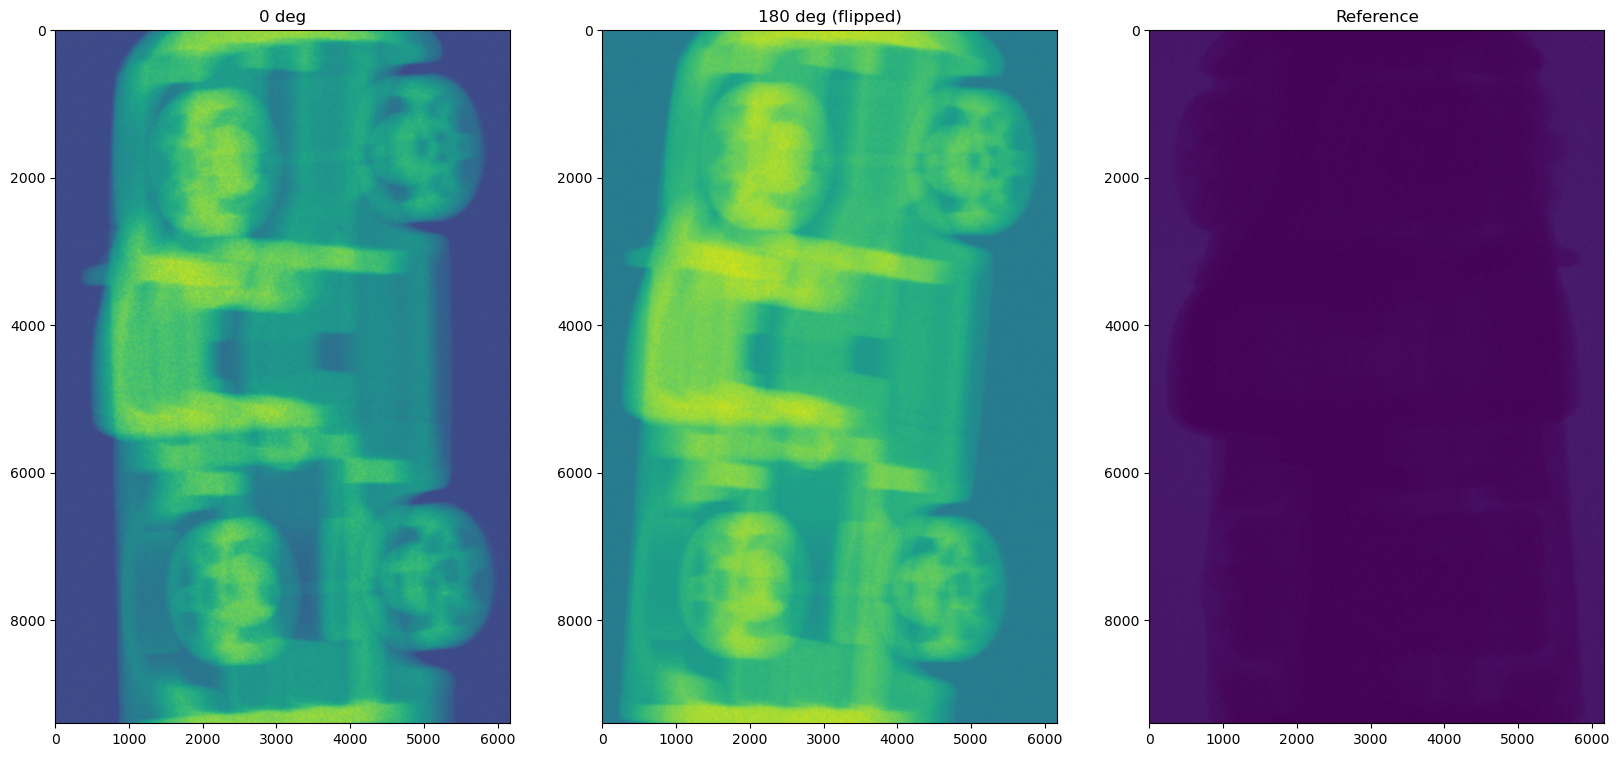

In [70]:
f, ax = plt.subplots(1, 3, figsize=(20, 9))
ax[0].imshow(proj_mlog[proj000_idx])
ax[0].set_title('0 deg')
ax[1].imshow(np.fliplr(proj_mlog[proj180_idx]))
ax[1].set_title('180 deg (flipped)')
ax[2].imshow(proj_crop_min)
ax[2].set_title('Reference')

> Finding the rotation axis position...
> Select ROI 1
ROI selected: ymin = 717 , ymax = 7274 , xmin = 124 , xmax = 6037
Rotation axis Found!
offset = -102.5    tilt angle = -2.5813322368287515 °
average of residuals  =  0.06574057


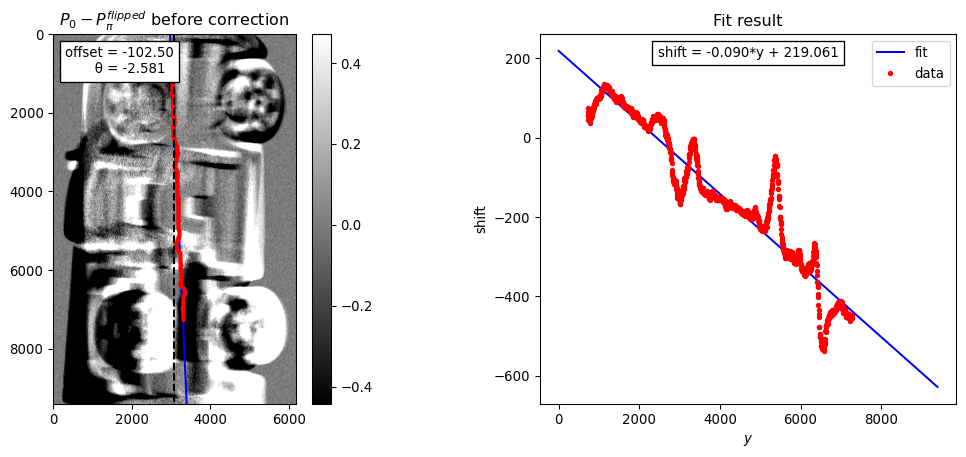

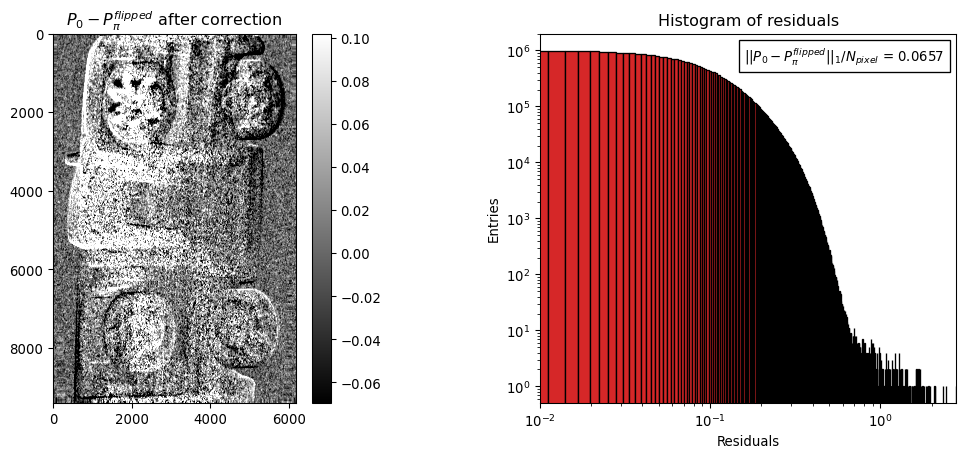

In [71]:
# Tilt correction (neutompy)
nroi = 1
use_input = False
# use_input = True
shift_input = 9.0
theta_input = 0.043059415809209155
proj_0 = proj_mlog[proj000_idx]
proj_180 = proj_mlog[proj180_idx]
if use_input:
    tt_offset = shift_input
    tt_ang = theta_input
    # tt_offset = np.float64(shift_input)
    # tt_ang = np.float64(theta_input)
else:
    tt_offset, tt_ang = ntp.find_COR(proj_0=proj_0, proj_180=proj_180, nroi=nroi, ref_proj=proj_crop_min)

In [72]:
proj_mlog_tilt = ntp.correction_COR(norm_proj=proj_mlog, proj_0=proj_0, proj_180=proj_180, shift=0, theta=tt_ang)
history_dict = rocku.log(history_dict, 'tilt_corr_used', 'neutompy')

> Correcting rotation axis misalignment...


100%|████████████████████████████████████| 181/181 [00:58<00:00,  3.07 images/s]


# Focused ROI for the next steps

Time: 6.9569514349568635 s


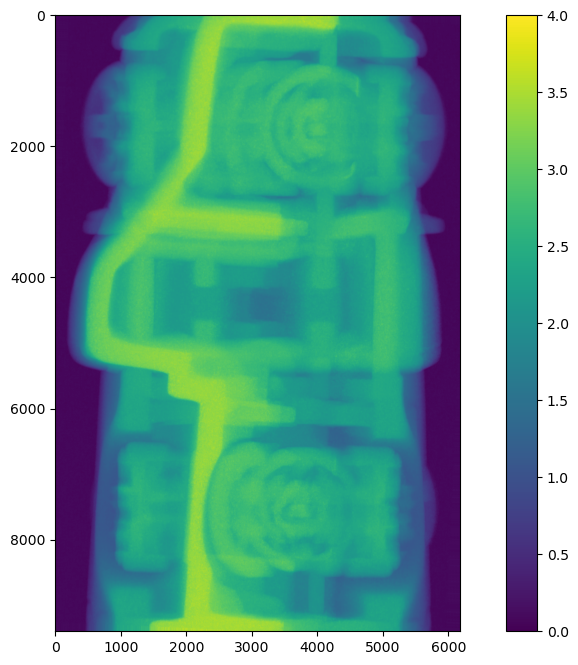

In [73]:
t0 = timeit.default_timer()
proj_mlog_tilt_min = np.max(proj_mlog_tilt, axis=0)
t1 = timeit.default_timer()
print("Time: {} s".format(t1-t0))
plt.imshow(proj_mlog_tilt_min, vmin = 0, vmax=4)
plt.colorbar()
plt.show()

In [74]:
### Define ring removal roi
# define_roi = True
define_roi = False

define_roi_top = 0#270
define_roi_bottom = 2000
############################################
############################################
###################### need to change end
shift = int(abs(tt_offset))
define_roi_left = shift
# define_roi_right = -1*shift
define_roi_right = -1


proj_mlog_tilt_min_crop = rocku.crop(proj_mlog_tilt_min, define_roi_left, define_roi_right, define_roi_top, define_roi_bottom, define_roi)
proj_mlog_roi = rocku.crop(proj_mlog_tilt, define_roi_left, define_roi_right, define_roi_top, define_roi_bottom, define_roi)
# Covert to sinogram
sino_mlog_roi = np.moveaxis(proj_mlog_roi, 1, 0)

define_roi_dict = {
    'left': define_roi_left,
    'right': define_roi_right,
    'top': define_roi_top,
    'bottom': define_roi_bottom
}
history_dict = rocku.log(history_dict, 'define_roi', define_roi)
if define_roi:
    history_dict = rocku.log(history_dict, 'define_roi_dict', define_roi_dict)
    print("Defined ROI:")
    plt.imshow(proj_mlog_tilt_min_crop, vmax=1)
    plt.colorbar()
    plt.show()

# Test tilt and COR by reconstruct slices

In [75]:
# # Covert to sinogram
# sino_mlog_tilt = np.moveaxis(proj_mlog_tilt, 1, 0)

print("Finding the center of rotation (COR)...")
# Use Vo's approach for 360 sinogram (180sinogram is calc.find_center_vo)
rot_center_180 = calc.find_center_vo(sino_mlog_roi[int(sino_mlog_roi.shape[0]/2)][:proj180_idx], ncore=ncore)
print('Estimated center of rotation (COR) with 0-180 deg:', rot_center_180)
history_dict = rocku.log(history_dict, 'rot_center_180', rot_center_180)

# rot_center_360 = calc.find_center_360(sino_mlog_roi[int(sino_mlog_roi.shape[0]/2)], win_width=800, ncore=ncore)[0]
# print('Estimated center of rotation (COR) with 0-360 deg:', rot_center_360)
# history_dict = rocku.log(history_dict, 'rot_center_360', rot_center_360)

Finding the center of rotation (COR)...
Estimated center of rotation (COR) with 0-180 deg: 3177.25


Center of rotation: 3177.25
Tilt theta applied: -2.5813322368287515
Time cost 4.548080923035741 s


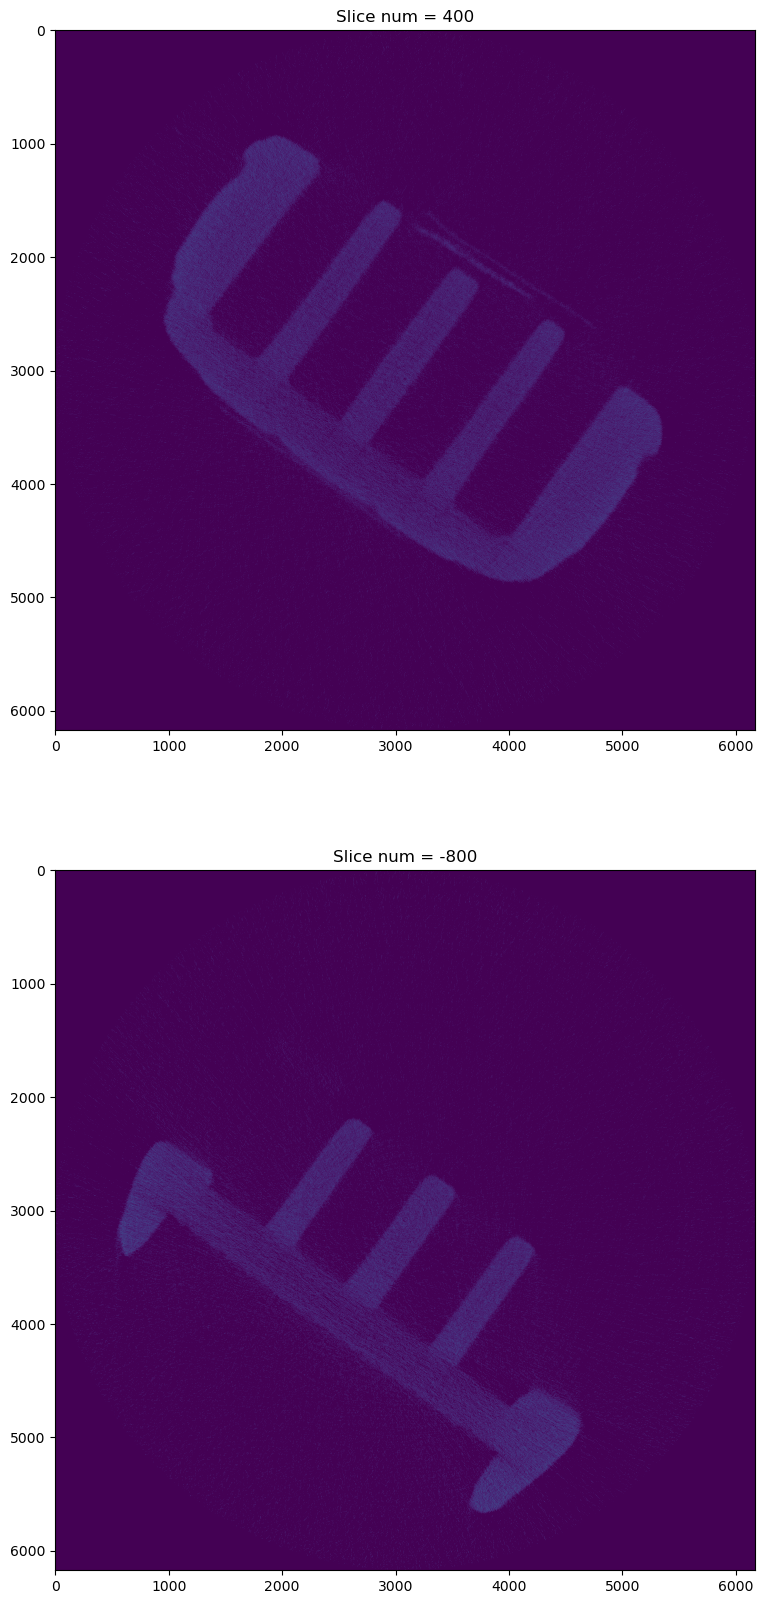

In [76]:
###################### need to change start
slice_idx_list = [400, -800]
pix_um = None
# pix_um = 42 # um
# pix_um = 7.8*pixel_bin_size # um
# pix_um = 15.97*pixel_bin_size # um
# pix_um = 15.97*3 # um
rot_center = rot_center_180
# rot_center = rot_center_360

recon_crop = False
# recon_crop = True
recon_crop_left = 200
recon_crop_right = 1200
recon_crop_top = 200
recon_crop_bottom = 1200
###################### need to change end
######################################
## Recon some slices to check the sharpness
history_dict = rocku.log(history_dict, 'rot_center', rot_center)
print("Center of rotation:", rot_center)
history_dict = rocku.log(history_dict, 'tilt_corr_theta', tt_ang)
print("Tilt theta applied:", tt_ang)
t0 = timeit.default_timer()
f, ax = plt.subplots(len(slice_idx_list), 1, figsize=(20, 20))

for num, e_idx in enumerate(slice_idx_list):
    _rec_img = rec.gridrec_reconstruction(sino_mlog_roi[e_idx], rot_center, angles=ang_rad, 
                                          apply_log=False, ratio=1.0, filter_name='shepp', pad=100,
                                          ncore=ncore
                                     )
    _rec_img = rocku.crop(_rec_img, recon_crop_left, recon_crop_right, recon_crop_top, recon_crop_bottom, recon_crop)
    if pix_um is not None:
        pix_cm = pix_um/10000
        _rec_img = _rec_img/pix_cm
    ax[num].imshow(_rec_img, vmin=0)
    ax[num].set_title('Slice num = {}'.format(e_idx))
t1 = timeit.default_timer()
print("Time cost {} s".format((t1-t0)))

In [ ]:
### Optional tests with different slice index
slice_idx_list = [480, 2800]
f, ax = plt.subplots(len(slice_idx_list), 1, figsize=(20, 20))
for num, e_idx in enumerate(slice_idx_list):
    _rec_img = rec.gridrec_reconstruction(sino_mlog_roi[e_idx], rot_center, angles=ang_rad, 
                                          apply_log=False, ratio=1.0, filter_name='shepp', pad=100,
                                          ncore=ncore
                                     )
    _rec_img = rocku.crop(_rec_img, recon_crop_left, recon_crop_right, recon_crop_top, recon_crop_bottom, recon_crop)
    if pix_um is not None:
        pix_cm = pix_um/10000
        _rec_img = _rec_img/pix_cm
    ax[num].imshow(_rec_img, vmin=0)
    ax[num].set_title('Slice num = {}'.format(e_idx))

# Ring Artifact Removal

In [77]:
# ring_algo = 'Vo' ######### (a) Vo's approach from tomopy (faster)
# ring_algo = 'bm3d' ######### (b) bm3d approach (slow, but generally better)
# ring_algo = 'bm3dgpu' ######### (b) bm3d approach (slow, but generally better)
# ring_algo = 'bm3dornl' ######### (c) bm3dornl GPU
ring_algo = None
#################################################################################
t0 = timeit.default_timer()
proj_mlog_rmv = rocku.remove_ring(proj_mlog=proj_mlog_roi, ring_algo=ring_algo, ncore=ncore)
t1 = timeit.default_timer()
print("Time cost {} min".format((t1-t0)/60))
history_dict = rocku.log(history_dict, 'ring_removal', ring_algo)
proj_mlog_to_recon = proj_mlog_rmv.astype(np.float32)
sino_mlog_to_recon = np.moveaxis(proj_mlog_to_recon, 1, 0)

Time cost 6.272185904284318e-07 min


Text(0.5, 1.0, 'Difference')

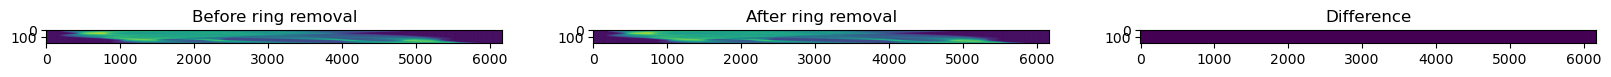

In [78]:
slice_num = None
# slice_num = 140
#######################
if slice_num is None:
    slice_num = int(proj_mlog_roi.shape[1]/2)
f, ax = plt.subplots(1, 3, figsize=(20, 9))
ax[0].imshow(sino_mlog_roi[slice_num])
ax[0].set_title('Before ring removal')
ax[1].imshow(sino_mlog_to_recon[slice_num])
ax[1].set_title('After ring removal')
ax[2].imshow(sino_mlog_to_recon[slice_num]-sino_mlog_roi[slice_num])
ax[2].set_title('Difference')

# Reconstruction
## 1. Gridrec preview

Center of rotation 3177.25
Time cost 0.03756096741805474 min


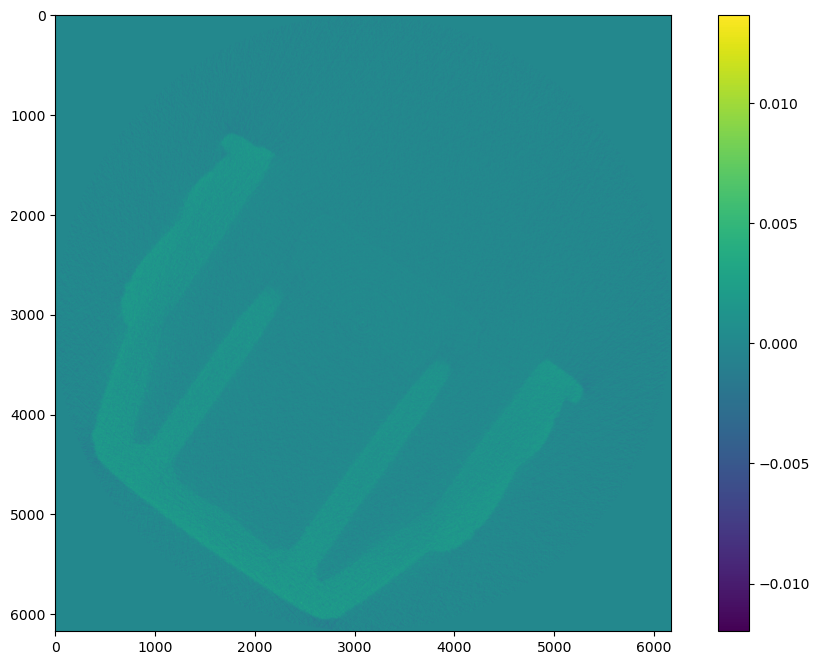

In [79]:
slice_num = None
# slice_num = 300
# full_360 = True
full_360 = False
#######################
if full_360:
    start_ang_idx = proj000_idx
    end_ang_idx = proj360_idx
    rot_center = rot_center_360
else:
    start_ang_idx = proj000_idx
    end_ang_idx = proj180_idx
    rot_center = rot_center_180
if slice_num is None:
    slice_num = int(proj_mlog_roi.shape[1]/2)
print("Center of rotation", rot_center)
t0 = timeit.default_timer()
rec_img1 = rec.gridrec_reconstruction(sino_mlog_to_recon[slice_num,start_ang_idx:end_ang_idx,:], rot_center, angles=ang_rad[start_ang_idx:end_ang_idx], apply_log=False,
                                      ratio=1.0,
                                      filter_name='shepp',
                                      pad=100,
                                      ncore=ncore
                                     )
t1 = timeit.default_timer()
print("Time cost {} min".format((t1-t0)/60))
plt.imshow(rec_img1)
plt.colorbar()
plt.show()

## 2. FBP preview

Center of rotation 3177.25
Time cost 0.016791480201451728 min


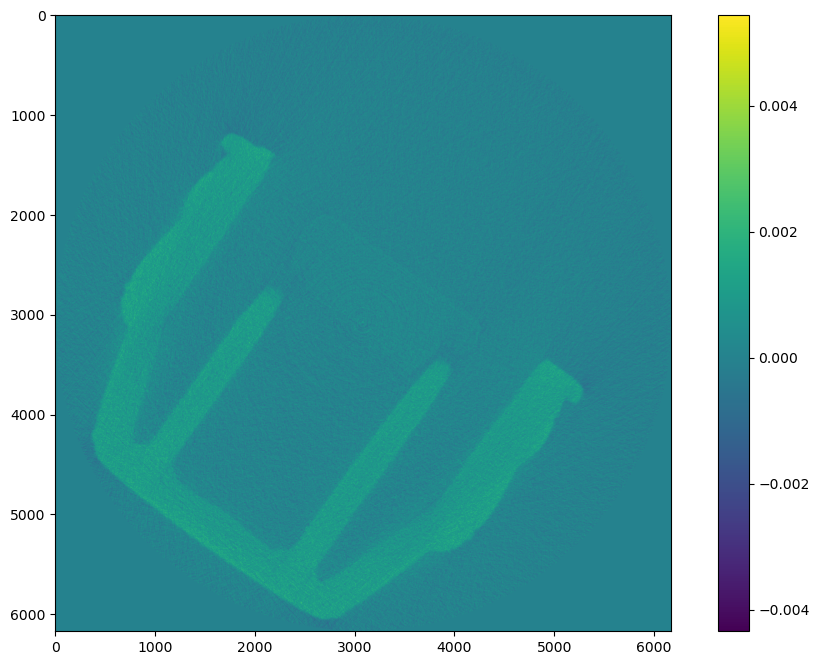

In [80]:
print("Center of rotation", rot_center)
t0 = timeit.default_timer()
rec_img1 = rec.fbp_reconstruction(sino_mlog_to_recon[slice_num,start_ang_idx:end_ang_idx,:], rot_center, angles=ang_rad[start_ang_idx:end_ang_idx], apply_log=False,
                                  ramp_win=None,
                                  filter_name='hann',
                                  pad=None,
                                  pad_mode='edge',
                                  ncore=ncore,
                                  gpu=False,
#                                   gpu=True, block=(16, 16), # Version error 7.8, current version 7.5
                                 )
t1 = timeit.default_timer()
print("Time cost {} min".format((t1-t0)/60))
plt.imshow(rec_img1)
plt.colorbar()
plt.show()

## 3. ASTRA preview

Center of rotation 3177.25
Time cost 0.17253081323190902 min


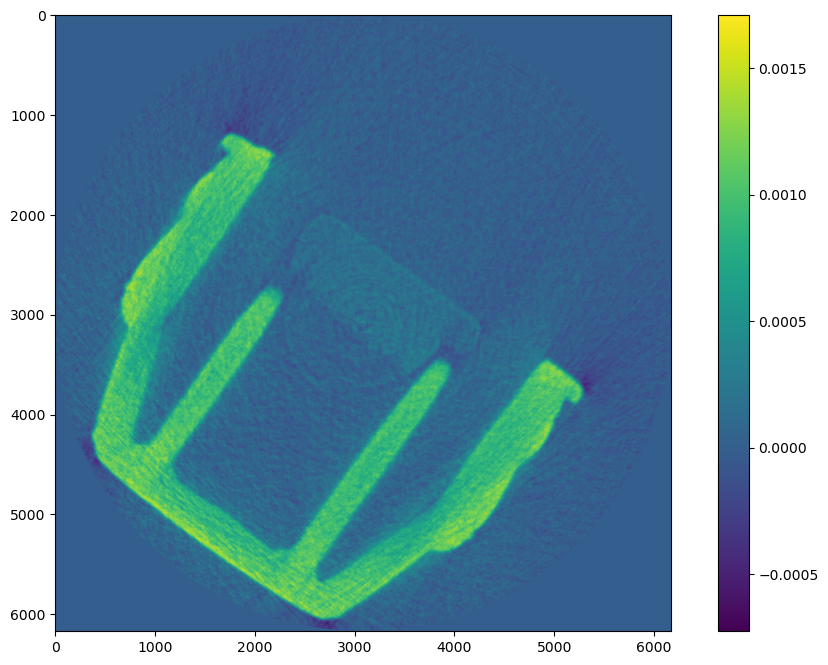

In [81]:
print("Center of rotation", rot_center)
# Reconstruction algorithms. 
# For CPU: 'FBP', 'SIRT', 'SART', 'ART', and CGLS'. 
# For GPU: 'FBP_CUDA', 'SIRT_CUDA', 'SART_CUDA', and 'CGLS_CUDA'.
t0 = timeit.default_timer()
rec_img1 = rec.astra_reconstruction(sino_mlog_to_recon[slice_num,start_ang_idx:end_ang_idx,:], rot_center, angles=ang_rad[start_ang_idx:end_ang_idx], apply_log=False,
                                    method='SIRT_CUDA',
                                    # method='SART_CUDA',
#                                     method='FBP_CUDA',
                                    ratio=1.0,
                                    filter_name='hann',
                                    pad=None,
                                    num_iter=300,
                                    ncore=ncore,
                                   )
t1 = timeit.default_timer()
print("Time cost {} min".format((t1-t0)/60))
plt.imshow(rec_img1)
plt.colorbar()
plt.show()

## 4. svMBIR preview

In [ ]:
print("Center of rotation", rot_center)
T = 2.0
p = 1.2
sharpness = 0.0
snr_db = 30.0
center_offset= -(proj_mlog_to_recon.shape[2]/2 - rot_center)
t0 = timeit.default_timer()
recon_mbir = svmbir.recon(proj_mlog_to_recon[start_ang_idx:end_ang_idx,slice_num,:],
                          angles=np.array(ang_rad)[start_ang_idx:end_ang_idx], # In radians
                          weight_type='transmission', 
                          center_offset=center_offset, 
                          snr_db=snr_db, p=p, T=T, sharpness=sharpness, 
                          positivity=False,
                          max_iterations=100,
                          num_threads= 112,
                          verbose=1,# verbose: display of reconstruction: 0 is minimum, 1 is regular
                          svmbir_lib_path = svmbir_path,
                         )
recon_mbir = np.fliplr(np.rot90(recon_mbir, k=1, axes=(1,2)))
t1 = timeit.default_timer()
print("Time cost {} min".format((t1-t0)/60))
plt.imshow(recon_mbir[0])
plt.colorbar()
plt.show()

# Beam hardening correction (optional)

In [ ]:
###################### need to change start
idx = 1600
line_loc = 370
bh_q = 0.02
bh_n = 15
bh_opt = True
###################### need to change end
t0 = timeit.default_timer()
rec_img = rec.gridrec_reconstruction(sino_mlog_to_recon[idx], rot_center, angles=ang_rad, apply_log=False)
rec_img = rocku.crop(rec_img, recon_crop_left, recon_crop_right, recon_crop_top, recon_crop_bottom, recon_crop)

proj_norm_to_recon = np.exp(np.negative(proj_mlog_to_recon))
proj_norm_to_recon_bh_corr = corr.beam_hardening_correction(mat=proj_norm_to_recon, q=bh_q, n=bh_n, opt=bh_opt)
proj_mlog_to_recon_bh_corr = np.negative(np.log(proj_norm_to_recon_bh_corr))
sino_mlog_to_recon_bh_corr = np.moveaxis(proj_mlog_to_recon_bh_corr, 1, 0)
rec_img_bh_corr = rec.gridrec_reconstruction(sino_mlog_to_recon_bh_corr[idx], rot_center, angles=ang_rad, apply_log=False)
rec_img_bh_corr = rocku.crop(rec_img_bh_corr, recon_crop_left, recon_crop_right, recon_crop_top, recon_crop_bottom, recon_crop)

In [ ]:
start = (line_loc, 0)
end = (line_loc, rec_img.shape[1]-1)
profile = profile_line(rec_img, start, end)
profile_bh_corr = profile_line(rec_img_bh_corr, start, end)
fig, ax = plt.subplots(2, 2)
ax[0][0].set_title('Image')
ax[0][0].imshow(rec_img)
ax[0][0].plot([start[1], end[1]], [start[0], end[0]], 'r')
ax[0][1].set_title('Profile')
ax[0][1].plot(profile)
# ax[1][0].set_title('Image_BH')
ax[1][0].imshow(rec_img_bh_corr)
ax[1][0].plot([start[1], end[1]], [start[0], end[0]], 'r')
# ax[1][1].set_title('Profile_BH')
ax[1][1].plot(profile_bh_corr)
fig.show()
t1 = timeit.default_timer()
print("Time: {} mins".format((t1-t0)/60))

# Pick one method to recon the defined ring removed ROI

In [56]:
# pix_um = 15.97 * pixel_bin_size # um
# pix_um = 7.8 * pixel_bin_size # um
# pix_um = 42 # um
pix_um = None

recon_algo = 'gridrec'
# recon_algo = 'SIRT_CUDA'
# recon_algo = 'svmbir'

# full_360 = True
full_360 = False

slice_by_slice = True
# slice_by_slice = False
##################################
if full_360:
    start_ang_idx = proj000_idx
    end_ang_idx = proj360_idx
    rot_center = rot_center_360
else:
    start_ang_idx = proj000_idx
    end_ang_idx = proj180_idx
    rot_center = rot_center_180
if not slice_by_slice:
    t0 = timeit.default_timer()
    ####################### tomopy algorithms (gridrec and fbp are faster than algotom) ##########################
    if recon_algo in ['art', 'bart', 'fbp', 'gridrec',
                      'mlem', 'osem', 'ospml_hybrid', 'ospml_quad',
                      'pml_hybrid', 'pml_quad', 'sirt', 'tv', 'grad', 'tikh']:
        recon = tomopy.recon(proj_mlog_to_recon[start_ang_idx:end_ang_idx,:,:], ang_rad[start_ang_idx:end_ang_idx], center=rot_center,
                             algorithm=recon_algo,
                             ncore=ncore, 
    #                          nchunk=nchunk
                            )
    ################################################ algotom algorithms ##########################################
        #### ASTRA
    if recon_algo in ['FBP', 'SIRT', 'SART', 'ART', 'CGLS', 'FBP_CUDA', 'SIRT_CUDA', 'SART_CUDA', 'CGLS_CUDA']:
        recon = rec.astra_reconstruction(proj_mlog_to_recon[start_ang_idx:end_ang_idx,:,:], 
                                         rot_center, 
                                         angles=ang_rad[start_ang_idx:end_ang_idx],
                                         apply_log=False,
                                         method=recon_algo,
                                         ratio=1.0,
                                         filter_name='hann',
                                         pad=None,
                                         num_iter=300,
                                         ncore=ncore
                                        )
        recon = np.moveaxis(recon, 1, 0) 
        #### gridrec from algotom
    if recon_algo == 'gridrec_algo':
        recon = rec.gridrec_reconstruction(proj_mlog_to_recon[start_ang_idx:end_ang_idx,:,:],
                                           rot_center, 
                                           angles=ang_rad[start_ang_idx:end_ang_idx], 
                                           apply_log=False,
                                           ratio=1.0,
                                           filter_name='shepp',
                                           pad=100,
                                           ncore=ncore
                                          )
        recon = np.moveaxis(recon, 1, 0)
        #### FBP from algotom
    if recon_algo == 'fbp_algo':
        recon = rec.fbp_reconstruction(proj_mlog_to_recon[start_ang_idx:end_ang_idx,:,:], 
                                       rot_center, 
                                       angles=ang_rad[start_ang_idx:end_ang_idx], 
                                       apply_log=False,
                                       ramp_win=None,
                                       filter_name='hann',
                                       pad=None,
                                       pad_mode='edge',
                                       ncore=ncore,
                                       gpu=False,
    #                                   gpu=True, block=(16, 16), # Version error 7.8, current version 7.5
                                      )
        recon = np.moveaxis(recon, 1, 0)
    ################################################### MBIR #####################################################
    if recon_algo == 'svmbir':
        T = 2.0
        p = 1.2
        sharpness = 0.0
        snr_db = 30.0
        center_offset= -(proj_mlog_to_recon.shape[2]/2 - rot_center)
        recon = svmbir.recon(
            proj_mlog_to_recon[start_ang_idx:end_ang_idx,:,:],
    #         proj_mlog_to_recon[:,595:605,:],
            angles=np.array(ang_rad)[start_ang_idx:end_ang_idx], # In radians
            weight_type='transmission', 
            center_offset=center_offset, 
            snr_db=snr_db, p=p, T=T, sharpness=sharpness, 
            positivity=False,
            max_iterations=50,
            num_threads= 112,
            verbose=1,# verbose: display of reconstruction: 0 is minimum, 1 is regular
            svmbir_lib_path = svmbir_path,
        )
        recon = np.fliplr(np.rot90(recon, k=1, axes=(1,2)))
    ##################################
    if pix_um is not None:
        pix_cm = pix_um/10000
        recon = recon/pix_cm
        history_dict = rocku.log(history_dict, 'pixel_size_um', pix_um)
        history_dict = rocku.log(history_dict, 'recon_unit', 'cm-1')
        recon_unit = 'cm-1'
    else:
        history_dict = rocku.log(history_dict, 'recon_unit', 'px-1')
        recon_unit = 'px-1'
    history_dict = rocku.log(history_dict, 'start_ang_idx', start_ang_idx)
    history_dict = rocku.log(history_dict, 'end_ang_idx', end_ang_idx)
    history_dict = rocku.log(history_dict, 'rot_center', rot_center)
    history_dict = rocku.log(history_dict, 'recon_algo', recon_algo)
    t1 = timeit.default_timer()
    print("Time cost {} min".format((t1-t0)/60))
else:
    print("Run the slice by slice recon cell below.")

Run the slice by slice recon cell below.


In [86]:
# save_to = instrument + "/IPTS-"+ipts+"/shared/processed_data/rockit/"
save_to = instrument + "/IPTS-"+ipts+"/shared/rockit/" + sample_name
#########################
if save_to is None:
    print("Input a location to save!")
else:
    print('Saving to {}'.format(save_to))
    t0 = timeit.default_timer()
    for h_idx in tqdm(range(sino_mlog_to_recon.shape[0])):
        if recon_algo == 'gridrec':
            _rec_slice = rec.gridrec_reconstruction(sino_mlog_to_recon[h_idx,start_ang_idx:end_ang_idx,:], rot_center, angles=ang_rad[start_ang_idx:end_ang_idx], apply_log=False,
                                                    ncore=ncore
                                                   )
            # print(_rec_slice)
        if recon_algo == 'fbp':
            _rec_slice = rec.fbp_reconstruction(sino_mlog_to_recon[h_idx], rot_center, angles=ang_rad, apply_log=False,
                                                ncore=ncore,
                                                gpu=False,
    #                                             gpu=True, # Version error 7.8, current version 7.5
                                               )
        if recon_algo in ['FBP', 'SIRT', 'SART', 'ART', 'CGLS', 'FBP_CUDA', 'SIRT_CUDA', 'SART_CUDA', 'CGLS_CUDA']:
            _rec_slice = rec.astra_reconstruction(sino_mlog_to_recon[h_idx], rot_center, angles=ang_rad, apply_log=False,
                                                  method=recon_algo,
                                                  num_iter=300,
                                                  ncore=ncore)
        if recon_algo == 'svmbir':
            T = 2.0
            p = 1.2
            sharpness = 0.0
            snr_db = 30.0
            center_offset= -(proj_mlog_to_recon.shape[2]/2 - rot_center)
            _rec_mbir = svmbir.recon(proj_mlog_to_recon[:,h_idx,:],
                                      angles=np.array(ang_rad), # In radians
                                      weight_type='transmission', 
                                      center_offset=center_offset, 
                                      snr_db=snr_db, p=p, T=T, sharpness=sharpness, 
                                      positivity=False,
                                      max_iterations=100,
                                      num_threads= 112,
                                      verbose=1,# verbose: display of reconstruction: 0 is minimum, 1 is regular
                                      svmbir_lib_path = svmbir_path
                                     )
            _rec_slice = np.flipud(np.rot90(_rec_mbir[0]))
        if pix_um is not None:
            pix_cm = pix_um/10000
            _rec_slice = _rec_slice/pix_cm
        _slice_name = save_to + "/recon_" + f'{h_idx:05d}'
        dxchange.write_tiff(_rec_slice, fname=_slice_name, overwrite=True)
    if pix_um is not None:
        history_dict = rocku.log(history_dict, 'pixel_size_um', pix_um)
        history_dict = rocku.log(history_dict, 'recon_unit', 'cm-1')
        recon_unit = 'cm-1'
    else:
        history_dict = rocku.log(history_dict, 'recon_unit', 'px-1')
        recon_unit = 'px-1'
    # history_dict = rocku.log(history_dict, 'start_ang_idx', start_ang_idx)
    # history_dict = rocku.log(history_dict, 'end_ang_idx', end_ang_idx)
    history_dict = rocku.log(history_dict, 'rot_center', rot_center)
    history_dict = rocku.log(history_dict, 'recon_algo', recon_algo)
    t1 = timeit.default_timer()
    print("Time cost {} min".format((t1-t0)/60))

Saving to /SNS/VENUS/IPTS-33531/shared/rockit/truck_CT_data


100%|█████████████████████████████████████| 9399/9399 [5:55:33<00:00,  2.27s/it]

Time cost 355.5547273733498 min


# Crop reconstructed volume

In [ ]:
recon_max = np.mean(recon, axis=0)
plt.imshow(recon_max)#, vmax=2)
plt.colorbar()
plt.show()

In [ ]:
###################### need to change start
### Define crop roi
# recon_crop = True
recon_crop = False

recon_crop_left = 850
recon_crop_right = 1470
recon_crop_top = 960
recon_crop_bottom = 1580
###################### need to change end
recon_max_crop = rocku.crop(recon_max, recon_crop_left, recon_crop_right, recon_crop_top, recon_crop_bottom, recon_crop)
recon_crop_roi_dict = {
    'left': recon_crop_left,
    'right': recon_crop_right,
    'top': recon_crop_top,
    'bottom': recon_crop_bottom
}

if recon_crop:
    print("Recon ROI:")
    plt.imshow(recon_max_crop)#, vmax=2)
    plt.colorbar()
    plt.show()

In [ ]:
# Apply cropping to the whole recon volume and save crop info to h5
recon = rocku.crop(recon, recon_crop_left, recon_crop_right, recon_crop_top, recon_crop_bottom, recon_crop)
history_dict = rocku.log(history_dict, 'recon_crop', recon_crop)
if recon_crop:
    history_dict = rocku.log(history_dict, 'recon_crop_roi', recon_crop_roi_dict)

# Export recon files

In [31]:
################ change save path for your own
num_proj = len(ang_rad)
save_loc = instrument + "/IPTS-"+ipts+"/shared/processed_data/rockit/"
name_str = None
# name_str = 'lamino'
############################################################
if name_str is not None:
    save_name_str = "_".join([sample_name, name_str, "{}proj".format(num_proj), recon_algo])# + "_roi"
else:
    save_name_str = "_".join([sample_name, "{}proj".format(num_proj), recon_algo])# + "_roi"
save_to = save_loc + save_name_str
# save_to =  + sample_name + "_{}proj_".format(num_proj) + recon_algo
# save_to = "/netdisk/y9z/IPTS-"+ipts+"/recon/" + sample_name
print(save_to)
dxchange.write_tiff_stack(recon, fname=save_to + "/recon", overwrite=True, digit=4)

/HFIR/CG1D/IPTS-33592/shared/processed_data/rockit/2024_07_03_lam_circuit_small_lamino_2118proj_gridrec


# Export to HDF5

In [87]:
history_dict

{'crop': True,
 'crop_roi_dict': {'left': 200, 'right': -1, 'top': 200, 'bottom': -50},
 'gamma_filter': True,
 'gamma_diff': 20,
 'normalization': True,
 'pixel_bin_size': 1,
 'beam_fluc_corr': True,
 'beam_fluc_corr_roi_dict': {'left': 6000,
  'right': -1,
  'top': -200,
  'bottom': -1},
 'minus_log': True,
 'tilt_corr_used': 'neutompy',
 'define_roi': False,
 'rot_center_180': 3177.25,
 'rot_center': 3177.25,
 'tilt_corr_theta': -2.5813322368287515,
 'tilt_corr_shift': -98,
 'ring_removal': None,
 'recon_unit': 'px-1',
 'recon_algo': 'gridrec'}

In [90]:
if slice_by_slice:
    num_proj = len(ang_rad)
    name_str = None
    # name_str = 'lamino'
    ############################################################
    if name_str is not None:
        save_name_str = "_".join([sample_name, name_str, "{}proj".format(num_proj), recon_algo])# + "_roi"
    else:
        save_name_str = "_".join([sample_name, "{}proj".format(num_proj), recon_algo])# + "_roi"
output_hdf5_dir = instrument + "/IPTS-"+ipts+"/shared/autoreduce/hdf5/"
output_hdf5 = output_hdf5_dir + save_name_str + '.h5'
print(output_hdf5)

/SNS/VENUS/IPTS-33531/shared/autoreduce/hdf5/truck_CT_data_181proj_gridrec.h5


In [ ]:
if not os.path.exists(output_hdf5_dir):
    os.mkdir(output_hdf5_dir)
with h5f.File(output_hdf5, mode='a') as f:
    f.create_group('tomo/raw_ref')
    f.create_dataset('tomo/raw_ref/proj_min', data=proj_min)
    f.create_dataset('tomo/raw_ref/ob_min', data=ob_min)
    f.create_dataset('tomo/raw_ref/dc_max', data=dc_max)
    f.create_dataset('tomo/raw_ref/proj_crop_roi_min', data=proj_crop_min)
    if fluc_corr:
        f.create_dataset('tomo/raw_ref/fluc_corr_roi_min', data=bg_min)
    f.create_group('tomo/proj')
    f.create_dataset('tomo/proj/proj_norm_pre_tilt', data=proj_norm)
    f.create_dataset('tomo/proj/proj_mlog_pre_tilt', data=proj_mlog)
    f.create_dataset('tomo/proj/proj_mlog_pre_ring', data=proj_mlog_roi)
    f.create_dataset('tomo/proj/proj_mlog_to_recon', data=proj_mlog_to_recon)
    f.create_group('tomo/sino')
    f.create_dataset('tomo/sino/sino_mlog_pre_tilt', data=sino_mlog)
    f.create_dataset('tomo/sino/sino_mlog_pre_ring', data=sino_mlog_roi)
    f.create_dataset('tomo/sino/sino_mlog_to_recon', data=sino_mlog_to_recon)
    f.create_group('tomo/info')
    f.create_dataset('tomo/info/ang_deg', data=ang_deg, dtype=np.float32)
    f.create_dataset('tomo/info/ang_rad', data=ang_rad, dtype=np.float64)
    f.create_dataset('tomo/info/proj000_idx', data=(proj000_idx,), dtype=np.uint16)
    f.create_dataset('tomo/info/proj180_idx', data=(proj180_idx,), dtype=np.uint16)
    f.create_dataset('tomo/info/proj360_idx', data=(proj360_idx,), dtype=np.uint16)
    f.create_dataset('tomo/info/fname', data=fname_sorted)
    f.create_group('tomo/recon')
    f.create_dataset('tomo/recon/history', data=(str(history_dict),))
    f.create_dataset('tomo/recon/recon_unit', data=(recon_unit,))
    if not slice_by_slice:
        f.create_dataset('tomo/recon/recon_volume', data=recon)

In [ ]:
os.listdir(svmbir_path)